In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(1)

In [31]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
EMBEDDING_DIM = 10

In [32]:
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

In [46]:
# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}
data = []

In [47]:
print(vocab)

{'As', 'effect,', 'Computational', 'spirits', 'program.', 'inhabit', 'computer', 'other', 'programs', 'conjure', 'computational', 'process.', 'processes', 'data.', 'In', 'idea', 'process', 'pattern', 'we', 'to', 'rules', 'the', 'beings', 'directed', 'is', 'computers.', 'We', 'a', 'they', 'create', 'of', 'our', 'spells.', 'about', 'abstract', 'evolve,', 'that', 'manipulate', 'called', 'are', 'study', 'by', 'with', 'People', 'processes.', 'things', 'The', 'direct', 'evolution'}


In [48]:
for i in range(2, len(raw_text) - 2):
    context = [raw_text[i - 2], raw_text[i - 1],
               raw_text[i + 1], raw_text[i + 2]]
    target = raw_text[i]
    data.append((context, target))
print(data[:5])

[(['We', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'a'], 'idea')]


In [49]:
class CBOW(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim = -1)
        return log_probs
    
    def get_word_emdedding(self, word):
        word = torch.LongTensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)

In [50]:
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

In [51]:
losses = []
loss_function = nn.NLLLoss()

model = CBOW(vocab_size, EMBEDDING_DIM)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [52]:
for epoch in range(50):
    total_loss = 0
    for context, target in data:
        context_vector = make_context_vector(context, word_to_ix)
        model.zero_grad()
        log_probs = model(context_vector)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    losses.append(total_loss)

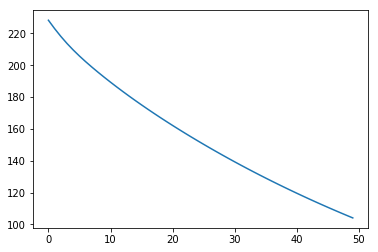

In [53]:
plt.plot(losses)

In [54]:
def get_index_of_max(input):
    index = 0
    for i in range(1, len(input)):
        if input[i] > input[index]:
            index = i
    return index

def get_max_prob_result(input, ix_to_word):
    return ix_to_word[get_index_of_max(input)]

In [58]:
print(format(' '.join(raw_text)))

We are about to study the idea of a computational process. Computational processes are abstract beings that inhabit computers. As they evolve, processes manipulate other abstract things called data. The evolution of a process is directed by a pattern of rules called a program. People create programs to direct processes. In effect, we conjure the spirits of the computer with our spells.


In [56]:
context = ['People','create','to', 'direct']
context_vector = make_context_vector(context, word_to_ix)

In [57]:
print(context_vector)

tensor([43, 29, 19, 47])


In [66]:
instance = model(context_vector)

In [67]:
print('Prediction: {}'.format(get_max_prob_result(instance[0], ix_to_word)))

Prediction: programs
